# WSI - Zadanie 5 <br/>
### 09.12.2023 <br/>
Wojciech Pobocha
318399


In [16]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def initQTable(gameEnvironment):
    return np.zeros((gameEnvironment.observation_space.n, gameEnvironment.action_space.n))

In [18]:
def chooseAction(gameEnvironment, state, QTable, epsilon):
    if np.random.uniform() < epsilon:
        action = gameEnvironment.action_space.sample()
    else:
        action = np.argmax(QTable[state, :])
    return action

In [19]:
def getUpdatedQTable(currentState, nextState, action, reward, QTable, beta, gamma):
    QTable[currentState, action] = QTable[currentState, action] + beta * (reward + gamma * np.max(QTable[nextState, :]) - QTable[currentState, action])
    return QTable

# Funkcja służąca do przejścia gry według optymalnych wartości z QTable

In [20]:
def playGame(gameEnvironment, QTable, maxSteps):
    currentState = gameEnvironment.reset()[0]
    isEndState = False
    totalReward = 0
    step = 0
    while not isEndState and step < maxSteps:
        action = chooseAction(gameEnvironment, currentState, QTable, 0)
        nextState, reward, isEndState, _,_ = gameEnvironment.step(action)
        currentState = nextState
        totalReward += reward
        step += 1
        
    return totalReward

In [40]:
def QLearning(gameEnvironment, maxEpisodes, maxT, gamma, beta, epsilon):
    if epsilon > 1 or epsilon < 0:
        raise ValueError("Epsilon must be between 0 and 1")
    if beta < 0:
        raise ValueError("Beta must be greater than 0")
    if gamma < 0:
        raise ValueError("Gamma must be greater than 0")
    QTable = initQTable(gameEnvironment)
    episode=0
    episodeRewards = []
    while episode < maxEpisodes:
        currentState = gameEnvironment.reset()[0]
        episodeRewards.append(0)
        t = 0
        while t < maxT:
            action = chooseAction(gameEnvironment, currentState, QTable, epsilon)
            nextState, reward, isEndState, _, _= gameEnvironment.step(action)
            episodeRewards[episode] += reward

            QTable = getUpdatedQTable(currentState,nextState, action, reward, QTable, beta, gamma)
            currentState = nextState
            if isEndState:
                break
            t+=1
        episode+=1
    return QTable, episodeRewards

In [22]:
def getMeanRewards(episodeRewards, windowSize):
    meanRewards = []
    for i in range(len(episodeRewards)//windowSize):
        meanRewards.append(np.mean(episodeRewards[max(0,i*windowSize):min(len(episodeRewards)-1,(i+1)*windowSize)]))
    return np.array(meanRewards)

In [23]:
def plotMeanRewards(episodeRewards, episodes, windowSize):
    plt.plot(np.linspace(0,episodes,windowSize),episodeRewards)
    plt.title(f'Mean Reward per {windowSize} episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

In [24]:
def getMeanRewardsForMultipleRuns(gameEnvironment, maxEpisodes, maxT, gamma, beta, epsilon, runs, windowSize):
    meanRewards = np.zeros(maxEpisodes//windowSize) 
    lastTableGame = 0
    for i in range(runs):
        QTable, episodeRewards = QLearning(gameEnvironment, maxEpisodes, maxT, gamma, beta, epsilon)
        meanRewards += getMeanRewards(episodeRewards, windowSize)
        lastTableGame += playGame(gameEnvironment, QTable, maxT)
    return meanRewards/(runs), lastTableGame/runs

# Opis eksperymentów
Testowanie parametrów algorytmu odbywało się 50 razy dla każdej pary **gamma** i **beta**, w której były liczone średnie błędy na przekrojach kolejnych epok i oceniana była jakość ostatecznej tabeli Q. Stałe parametry `maxEpisodes=100`, `maxT=100`, `epsilon=0.001` zostały wybrane na początku na podstawie specyfiki podanej gry i jakościowej oceny sprawności dążenia do optymalnej tabeli Q.

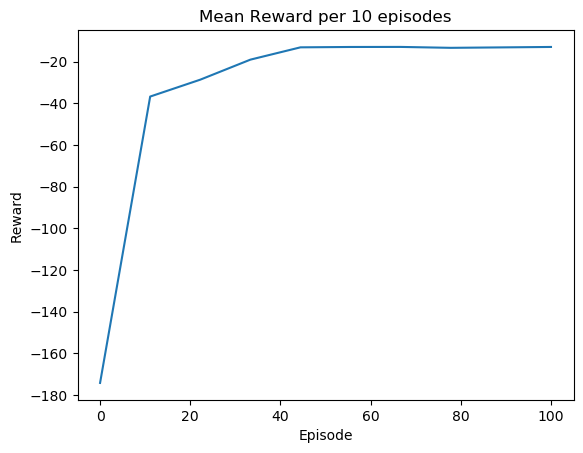

In [38]:
gameEnvironment = gym.make('CliffWalking-v0')
maxEpisodes = 100
maxT = 100
beta = 1
gamma = 1
epsilon = 0.001

QTable, episodeRewards = QLearning(gameEnvironment, maxEpisodes, maxT, gamma, beta, epsilon)
windowSize = 10
meanRewards, lastGame = getMeanRewardsForMultipleRuns(gameEnvironment, maxEpisodes, maxT, gamma, beta, epsilon, 50, windowSize)
plotMeanRewards(meanRewards, maxEpisodes, windowSize)

# Badanie wpływu parametrów beta i gamma na jakość działania algorytmu
*W tabeli zostały przedstawione średnie wyniki z 50 iteracji algorytmu QLearning*

| gamma | beta | 0-10    | 11-20  | 21-30  | 31-40  | 41-50  | 51-60  | 61-70  | 71-80  | 81-90  | 91-100 | ostateczny wynik |
|-------|------|---------|--------|--------|--------|--------|--------|--------|--------|--------|--------|------------------|
| 1     | 0.1  | -200.716 | -92.82 | -88.896 | -80.398 | -73.35  | -65.654 | -60.246 | -54.552 | -48.712 | -46.31111111 | -100.0 |
| 1     | 0.2  | -196.902 | -88.504 | -69.836 | -57.19  | -48.818 | -40.366 | -35.496 | -31.454 | -28.852 | -26.02666667 | -88.02 |
| 1     | 0.4  | -194.934 | -67.176 | -45.974 | -34.178 | -28.59  | -23.404 | -20.248 | -16.784 | -14.388 | -13.91555556 | -13.0 |
| 1     | 0.7  | -186.584 | -47.906 | -28.696 | -21.916 | -16.646 | -13.272 | -13.474 | -13.648 | -13.214 | -13.02222222 | -13.0 |
| 1     | 0.9  | -183.762 | -43.78  | -21.848 | -16.158 | -13.422 | -13.034 | -14.27  | -13.23  | -13.44  | -13.00666667 | -13.0 |
| 1.5   | 0.9  | -181.146 | -41.344  | -48.424  | -87.232  | -85.064   | -136.93   | -92.976  | -108.806  | -95.582   | -88.14666667 | -71.5          |
| 0.1   | 0.9  | -194.45  | -53.55  | -28.392 | -17.456 | -13.248 | -13.212 | -13.448 | -13.012 | -13.006 | -13.70888889 | -13.0 |
| 0.01  | 0.9  | -201.752 | -79.67  | -99.794 | -99.966 | -99.756 | -99.75  | -100.   | -99.822 | -99.914 | -99.79111111 | -100.0 |
| 0.05  | 0.9  | -199.276 | -62.71  | -30.192 | -20.326 | -13.458 | -13.222 | -13.874 | -13.416 | -13.024 | -13.03111111 | -13.0 |
| 0.5   | 0.9  | -183.216 | -42.772 | -24.688 | -17.362 | -13.214 | -13.232 | -13.232 | -13.242 | -13.208 | -13.49555556 | -13.0 |
| 0.9   | 0.9  | -184.51  | -43.352 | -22.944 | -15.36  | -13.012 | -13.016 | -13.656 | -13.438 | -13.87  | -13.26666667 | -13.0 |
| 0.8   | 0.9  | -184.578 | -43.246 | -22.834 | -15.326 | -13.238 | -13.654 | -13.22  | -13.212 | -13.224 | -13.01111111 | -13.0 |

# Komentarz do uzyskanych wyników
Zbyt mała wartość parametru beta sprawia, że algorytm nie ma szans znaleźć optymalnego rozwiązania, przynajmniej dla takiej określonej liczby epok (100), przy jej zwiększeniu ostatecznie odnajduje rozwiązanie. Zbyt wysoki parametr beta również powoduje złe działanie algorytmu - znajdowane jest rozwiązanie nieoptymalne. Parametr gamma również nie może być zbyt mały, ponieważ przez to nie polepsza swoich wyników wraz kolejnymi epokami, a praktycznie stoi w miejscu, co ma sens, ponieważ ważność patrzenia w przyszłość przez algorytm. 

# Wnioski i ocena algorytmu
Z powyższych eksperymentów wynika, że dobór parametrów ma kluczowy wpływ na jakość, a także prędkość działania. Algorytm dla tych parametrów i tego konkretnego agenta działa szybko, zakres ich poprawnych wartości jest dość szeroki, przez co ich szukanie nie sprawiało wielkich problemów. Ostatecznie sprawdza się dobrze, ponieważ w większości przypadków jego tablica Q zawierała optymalną strategie przejścia gry, czyli -13.